In [10]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

In [11]:
print(torch.cuda.is_available())

True


In [13]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out) 
            return out 

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

100%|██████████| 58/58 [00:35<00:00,  1.62it/s]


In [15]:
import os
print(os.getcwd()) 

/content


In [14]:
filename = './flowers_features_and_labels.npz'
np.savez(filename, f_all=f_all, y_all=y_all)

In [16]:
filename = './flowers_features_and_labels.npz'
load_dataset = np.load(filename)

### Question 21

Original pixels: 224 * 224 

Feature extracted per image: 4096

In [17]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]
print(num_features)

(3670, 4096) (3670,)
4096


### Question 23

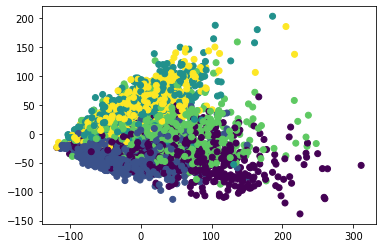

In [18]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

In [19]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(f_all)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


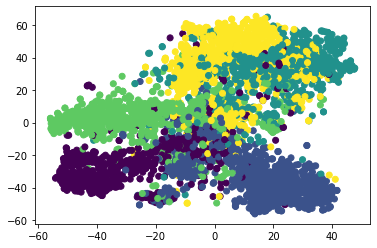

In [56]:
plt.scatter(*tsne.T, c=y_all)

### Question 24
---

#### Dimensionality Reduction

| Alternative | Hyperparameters   |
| ----------- | ----------------- |
| None        | N/A               |
| SVD         | r = 50            |
| UMAP        | n components = 50 |
| Autoencoder | num features = 50 |

#### Clustering

| Alternative | Hyperparameters   |
| ----------- | ----------------- |
| K-Means        | k=5               |
| Agglomerative Clustering        | n clusters = 5            |
| HDBSCAN        | min cluster size & min samples |



In [20]:
!pip install umap-learn

     |████████████████████████████████| 86 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 13.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=ce7e8c21973d3f71150baf9cfe606435cafcc1104a6d06072c675c4cabbae404
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=ca124db1f6ebb50944a23bb1edfd9f022818e438e17ab06c638fdbb07f961d31
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [21]:
!pip install hdbscan

     |████████████████████████████████| 6.4 MB 6.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311878 sha256=b65bae6655bf82586ae91c4efb9cc24f777e6ed4e42be62d5008a79ad60201a4
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan


In [22]:
from sklearn.decomposition import TruncatedSVD
import umap
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import hdbscan
from sklearn.metrics import rand_score

In [24]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components,n_features):
        super().__init__()
        self.n_components = n_components
        self.n_features = n_features  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

In [25]:
svd_reducer = TruncatedSVD(n_components=50)
umap_reducer = umap.UMAP(n_components=50)
autoen_reducer = Autoencoder(2,50)

In [26]:
data_None = f_all
data_svd = svd_reducer.fit_transform(f_all)
data_umap = umap_reducer.fit_transform(f_all)
data_autoencode =autoen_reducer.fit_transform(f_all)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


In [28]:
data_all = [data_None,data_svd,data_umap,data_autoencode]

In [27]:
km = KMeans(n_clusters=5, max_iter=1000, n_init=30, random_state=0)
AC = AgglomerativeClustering(n_clusters=5)
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1000)

In [30]:
score_km = []
for i in range(len(data_all)):
  if i == 0:
    msg = "None"
  elif i == 1:
    msg = "SVD"
  elif i == 2:
    msg = "UMAP"
  elif i == 3:
    msg = "Autoencoder"
  km.fit(data_all[i])
  randScore = rand_score(y_all,km.labels_)
  score_km.append(randScore)
  print("Dimensional Reduction: {}".format(msg))
  print("kM score: %0.4f"%(randScore))
  print("____________________________")


Dimensional Reduction: None
kM score: 0.7043
____________________________
Dimensional Reduction: SVD
kM score: 0.7043
____________________________
Dimensional Reduction: UMAP
kM score: 0.7945
____________________________
Dimensional Reduction: Autoencoder
kM score: 0.6537
____________________________


In [32]:
score_AC = []
for i in range(len(data_all)):
  if i == 0:
    msg = "None"
  elif i == 1:
    msg = "SVD"
  elif i == 2:
    msg = "UMAP"
  elif i == 3:
    msg = "Autoencoder"
  AC.fit(data_all[i])
  randScore = rand_score(y_all,AC.labels_)
  score_AC.append(randScore)
  print("Dimensional Reduction: {}".format(msg))
  print("Agglomerative Clustering score: %0.4f"%(randScore))
  print("____________________________")

Dimensional Reduction: None
Agglomerative Clustering score: 0.6862
____________________________
Dimensional Reduction: SVD
Agglomerative Clustering score: 0.6529
____________________________
Dimensional Reduction: UMAP
Agglomerative Clustering score: 0.7922
____________________________
Dimensional Reduction: Autoencoder
Agglomerative Clustering score: 0.6227
____________________________


In [35]:
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=None)

In [36]:
score_HDBSCAN = []
for i in range(len(data_all)):
  if i == 0:
    msg = "None"
  elif i == 1:
    msg = "SVD"
  elif i == 2:
    msg = "UMAP"
  elif i == 3:
    msg = "Autoencoder"
  hdbscan_clusterer.fit(data_all[i])
  randScore = rand_score(y_all,hdbscan_clusterer.labels_)
  score_HDBSCAN.append(randScore)
  print("Dimensional Reduction: {}".format(msg))
  print("Agglomerative Clustering score: %0.4f"%(randScore))
  print("____________________________")

Dimensional Reduction: None
Agglomerative Clustering score: 0.3785
____________________________
Dimensional Reduction: SVD
Agglomerative Clustering score: 0.4135
____________________________
Dimensional Reduction: UMAP
Agglomerative Clustering score: 0.6782
____________________________
Dimensional Reduction: Autoencoder
Agglomerative Clustering score: 0.6194
____________________________


In [58]:
# best result:

best_score = max(max(score_km),max(score_AC),max(score_HDBSCAN))
print("Best result is from (UMAP+KMEAN):{}".format(best_score))

Best result is from (UMAP+KMEAN):0.7944788169232906


### Questions 25 

In [46]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
      
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                ##################################
                # you should implement this part #
                ##################################
                output_y = self.model.forward(X_)
                loss = criterion(output_y,y_)
                optimizer.zero_grad() 
                loss.backward()
            # self.model.eval()
                raise NotImplementedError
        return self
    
    def eval(self, X_test, y_test):
        ##################################
        # you should implement this part #
        ##################################
        dataset = TensorDataset(X_test, y_test)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=False)
        i = 0
        sumScore = 0
        with torch.no_grad():
          for X,y in dataloader:
            output_y = self.model.forward(X_)
            randScore = rand_score(y_,output_y)
            sumScore += randScore
            i += 1
        finalScore = sumScore/i
        print(finalScore)
        # y_pred = self.model.predict(X_test)
        # print(rand_score(y_all,y_pred))
        raise NotImplementedError

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(f_all, y_all, test_size = 0.2)

In [47]:
mlp_model = MLP(4096)
mlp_model.train(X_train,y_train)

  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: ignored

In [48]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

In [50]:
y_pred = clf.predict(X_test)
rand_score(y_test,y_pred)

0.9187356650843274

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_umap, y_all, test_size = 0.2)

In [54]:
def mlp_train(data,y_all,data_name):
  X_train, X_test, y_train, y_test = train_test_split(data, y_all, test_size = 0.2)
  clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print("DR data:{}".format(data_name))
  
  score = rand_score(y_test,y_pred)
  print("MLP score:{}".format(score))
  print("_________________________")
  


In [55]:
mlp_train(data_None,y_all,"None")
mlp_train(data_svd,y_all,"svd")
mlp_train(data_umap,y_all,"umap")
mlp_train(data_autoencode,y_all,"autoencoder")

DR data:None
MLP score:0.9185981242402727
_________________________
DR data:svd
MLP score:0.9072826018266911
_________________________
DR data:umap
MLP score:0.8787038448241894
_________________________
DR data:autoencoder
MLP score:0.8180669191966128
_________________________
